In [17]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the combined feature vector CSV files for malicious and benign logs
malicious_filepath = "F:/FinalProject/new-model/csv-data/malicious.csv"
benign_filepath = "F:/FinalProject/new-model/csv-data/benign.csv"

malicious_df = pd.read_csv(malicious_filepath, header=None)
benign_df = pd.read_csv(benign_filepath, header=None)

# Add labels for the binary classification task
malicious_df['Label'] = 1
benign_df['Label'] = 0

# Combine the malicious and benign data
df = pd.concat([malicious_df, benign_df], ignore_index=True)

# Shuffle the DataFrame rows
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Tokenize and pad the text sequences

tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(df.iloc[:, 0])
sequences = tokenizer.texts_to_sequences(df.iloc[:, 0])
maxlen = 128  # Set your desired sequence length
padded_sequences = pad_sequences(sequences, maxlen=maxlen)

# Define the labels
labels = df['Label'].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Further split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=42)

# Build an LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=maxlen))
model.add(Bidirectional(LSTM(units=50, activation='relu')))
model.add(Dense(units=32, activation='sigmoid'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with early stopping and model checkpoint callbacks
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history=model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[ model_checkpoint])

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Save the trained model
model.save("F:/FinalProject/new-model/model.h5")

# Save the tokenizer
with open("F:/FinalProject/new-model/tokenizer.pkl", 'wb') as f:
    pd.to_pickle(tokenizer, f)

# Save the test data for evaluation and prediction
test_data = pd.DataFrame(data={'text': tokenizer.sequences_to_texts(X_test), 'Label': y_test})
test_data.to_csv("F:/FinalProject/new-model/test_data.csv", index=False)


Epoch 1/20
14/14 [==============================] - 5s 92ms/step - loss: 0.6966 - accuracy: 0.4988 - val_loss: 0.6709 - val_accuracy: 0.5283


C:\Users\lenovo\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
14/14 [==============================] - 2s 109ms/step - loss: 0.6156 - accuracy: 0.7518 - val_loss: 0.3757 - val_accuracy: 0.9434
Epoch 3/20
14/14 [==============================] - 2s 112ms/step - loss: 0.3997 - accuracy: 0.9672 - val_loss: 0.3260 - val_accuracy: 0.9811
Epoch 4/20
14/14 [==============================] - 1s 58ms/step - loss: 0.3517 - accuracy: 0.9461 - val_loss: 0.2456 - val_accuracy: 1.0000
Epoch 5/20
14/14 [==============================] - 1s 52ms/step - loss: 0.2143 - accuracy: 1.0000 - val_loss: 0.1784 - val_accuracy: 1.0000
Epoch 6/20
14/14 [==============================] - 1s 66ms/step - loss: 0.1613 - accuracy: 1.0000 - val_loss: 0.1448 - val_accuracy: 1.0000
Epoch 7/20
14/14 [==============================] - 1s 107ms/step - loss: 0.1315 - accuracy: 1.0000 - val_loss: 0.1152 - val_accuracy: 1.0000
Epoch 8/20
14/14 [==============================] - 1s 76ms/step - loss: 0.1019 - accuracy: 1.0000 - val_loss: 0.0801 - val_accuracy: 1.0000
Epoch 9/20

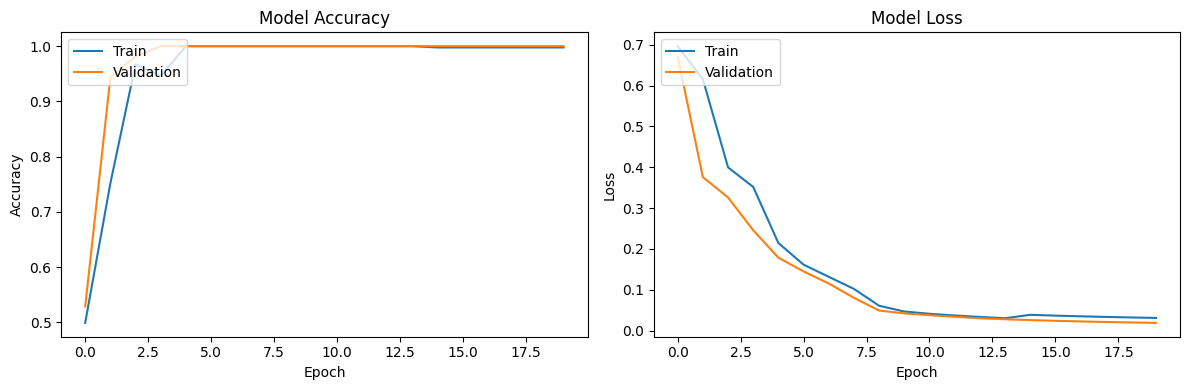

In [18]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [3]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_and_preprocess_model(model_path, tokenizer_path):
    # Load the trained LSTM model
    model = load_model(model_path)

    # Load the tokenizer used during training
    with open(tokenizer_path, 'rb') as f:
        tokenizer = pd.read_pickle(f)

    return model, tokenizer

# Load the saved test dataset
test_data_filepath = "F:/FinalProject/new-model/test_data.csv"
test_data = pd.read_csv(test_data_filepath)

# Load the trained model and tokenizer
model_path = "F:/FinalProject/new-model/model.h5"
tokenizer_path = "F:/FinalProject/new-model/tokenizer.pkl"

lstm_model, text_tokenizer = load_and_preprocess_model(model_path, tokenizer_path)

# Tokenize and pad the text sequences
sequences = text_tokenizer.texts_to_sequences(test_data['text'])
padded_sequences = pad_sequences(sequences, maxlen=lstm_model.input_shape[1])

# Make predictions using the loaded model
predictions = lstm_model.predict(padded_sequences)
print(predictions)

# Display the evaluation metrics
threshold = 0.5  # Adjust the threshold as needed
predicted_labels = (predictions > threshold).astype(int)
true_labels = test_data['Label'].values

loss, accuracy = model.evaluate(padded_sequences,true_labels)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")





4/4 [==============================] - 0s 18ms/step
[[0.98934835]
 [0.05172549]
 [0.98934835]
 [0.96442443]
 [0.9893651 ]
 [0.05172549]
 [0.98934835]
 [0.98934835]
 [0.05172549]
 [0.05172549]
 [0.05172549]
 [0.05172549]
 [0.05172549]
 [0.9893651 ]
 [0.98934835]
 [0.05172549]
 [0.05172549]
 [0.05172549]
 [0.05172549]
 [0.9893651 ]
 [0.05172549]
 [0.05172549]
 [0.05172549]
 [0.9893651 ]
 [0.9893651 ]
 [0.05172549]
 [0.05172549]
 [0.9893651 ]
 [0.98934835]
 [0.05172549]
 [0.9893651 ]
 [0.05172549]
 [0.05172549]
 [0.98934835]
 [0.9893651 ]
 [0.9893651 ]
 [0.9893651 ]
 [0.98934835]
 [0.98934835]
 [0.05172549]
 [0.98934835]
 [0.05172549]
 [0.05172549]
 [0.98934835]
 [0.05172549]
 [0.05172549]
 [0.05172549]
 [0.9893651 ]
 [0.05172549]
 [0.05172549]
 [0.05172549]
 [0.9893651 ]
 [0.98934835]
 [0.9893651 ]
 [0.98934835]
 [0.05172549]
 [0.05172549]
 [0.9867977 ]
 [0.9867977 ]
 [0.9893651 ]
 [0.05172549]
 [0.05172549]
 [0.98934835]
 [0.98934835]
 [0.05172549]
 [0.05172549]
 [0.05172549]
 [0.051725

In [19]:
from sklearn.metrics import confusion_matrix

# Predict on the validation set
y_val_pred = model.predict(X_val)
y_val_pred_binary = np.round(y_val_pred)

# Calculate confusion matrix
conf_matrix_val = confusion_matrix(y_val, y_val_pred_binary)

# Print the confusion matrix
print("Confusion Matrix - Validation Set:")
print(conf_matrix_val)

# Predict on the test set
y_test_pred = model.predict(X_test)
y_test_pred_binary = np.round(y_test_pred)

# Calculate confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred_binary)

# Print the confusion matrix
print("\nConfusion Matrix - Test Set:")
print(conf_matrix_test)

2/2 [==============================] - 0s 14ms/step
Confusion Matrix - Validation Set:
[[25  0]
 [ 0 28]]
4/4 [==============================] - 0s 16ms/step

Confusion Matrix - Test Set:
[[60  1]
 [ 1 58]]
